<a href="https://colab.research.google.com/github/drcrajc/iu_python_asssignment_task/blob/main/research_essay_oral_cancer_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 131 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
Class indices: {'cancer': 0, 'healthy': 1}
83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/5
3/5 [=================>............] - ETA: 8s - loss: 0.7035 - accuracy: 0.4627 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 [==============================] - 72s 10s/step - loss: 0.6244 - accuracy: 0.5802 - val_loss: 0.4490 - val_accuracy: 0.7368
Epoch 2/5
5/5 [==============================] - 35s 7s/step - loss: 0.4933 - accuracy: 0.7634 - val_loss: 0.3915 - val_accuracy: 0.8421
Epoch 3/5
5/5 [==============================] - 35s 6s/step - loss: 0.4378 - accuracy: 0.8321 - val_loss: 0.3629 - val_accuracy: 0.8947
Epoch 4/5
5/5 [==============================] - 34s 8s/step - loss: 0.3993 - accuracy: 0.8550 - val_loss: 0.3394 - val_accuracy: 0.8421
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.6994 - accuracy: 0.6111
Test Accuracy: 0.6111111044883728
1/1 [==============================] - 5s 5s/step


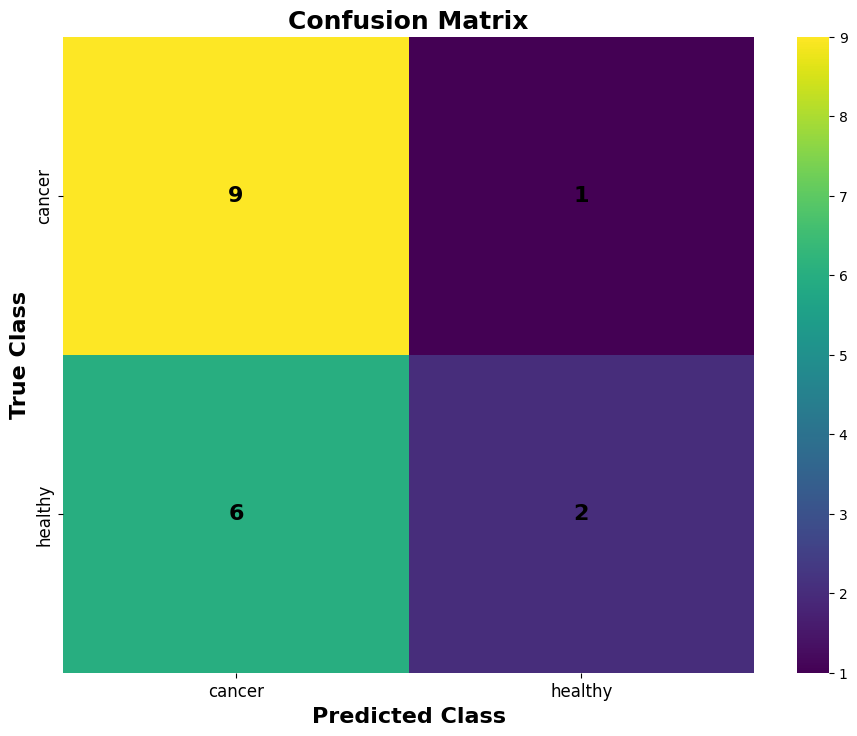

              precision    recall  f1-score   support

      cancer       0.60      0.90      0.72        10
     healthy       0.67      0.25      0.36         8

    accuracy                           0.61        18
   macro avg       0.63      0.57      0.54        18
weighted avg       0.63      0.61      0.56        18



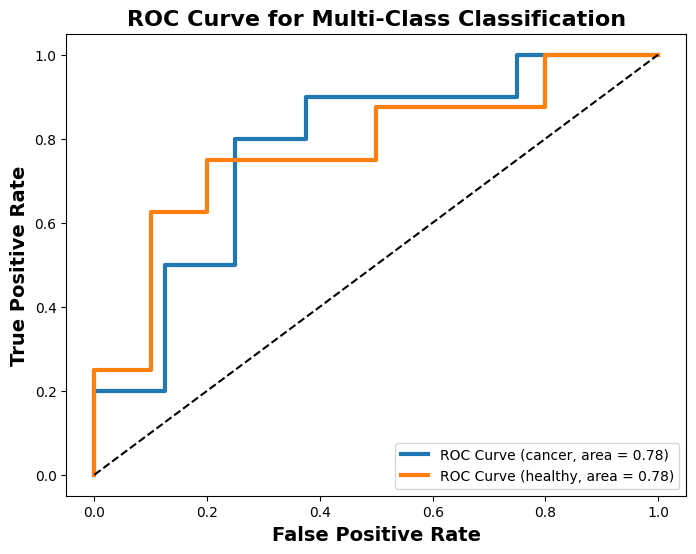

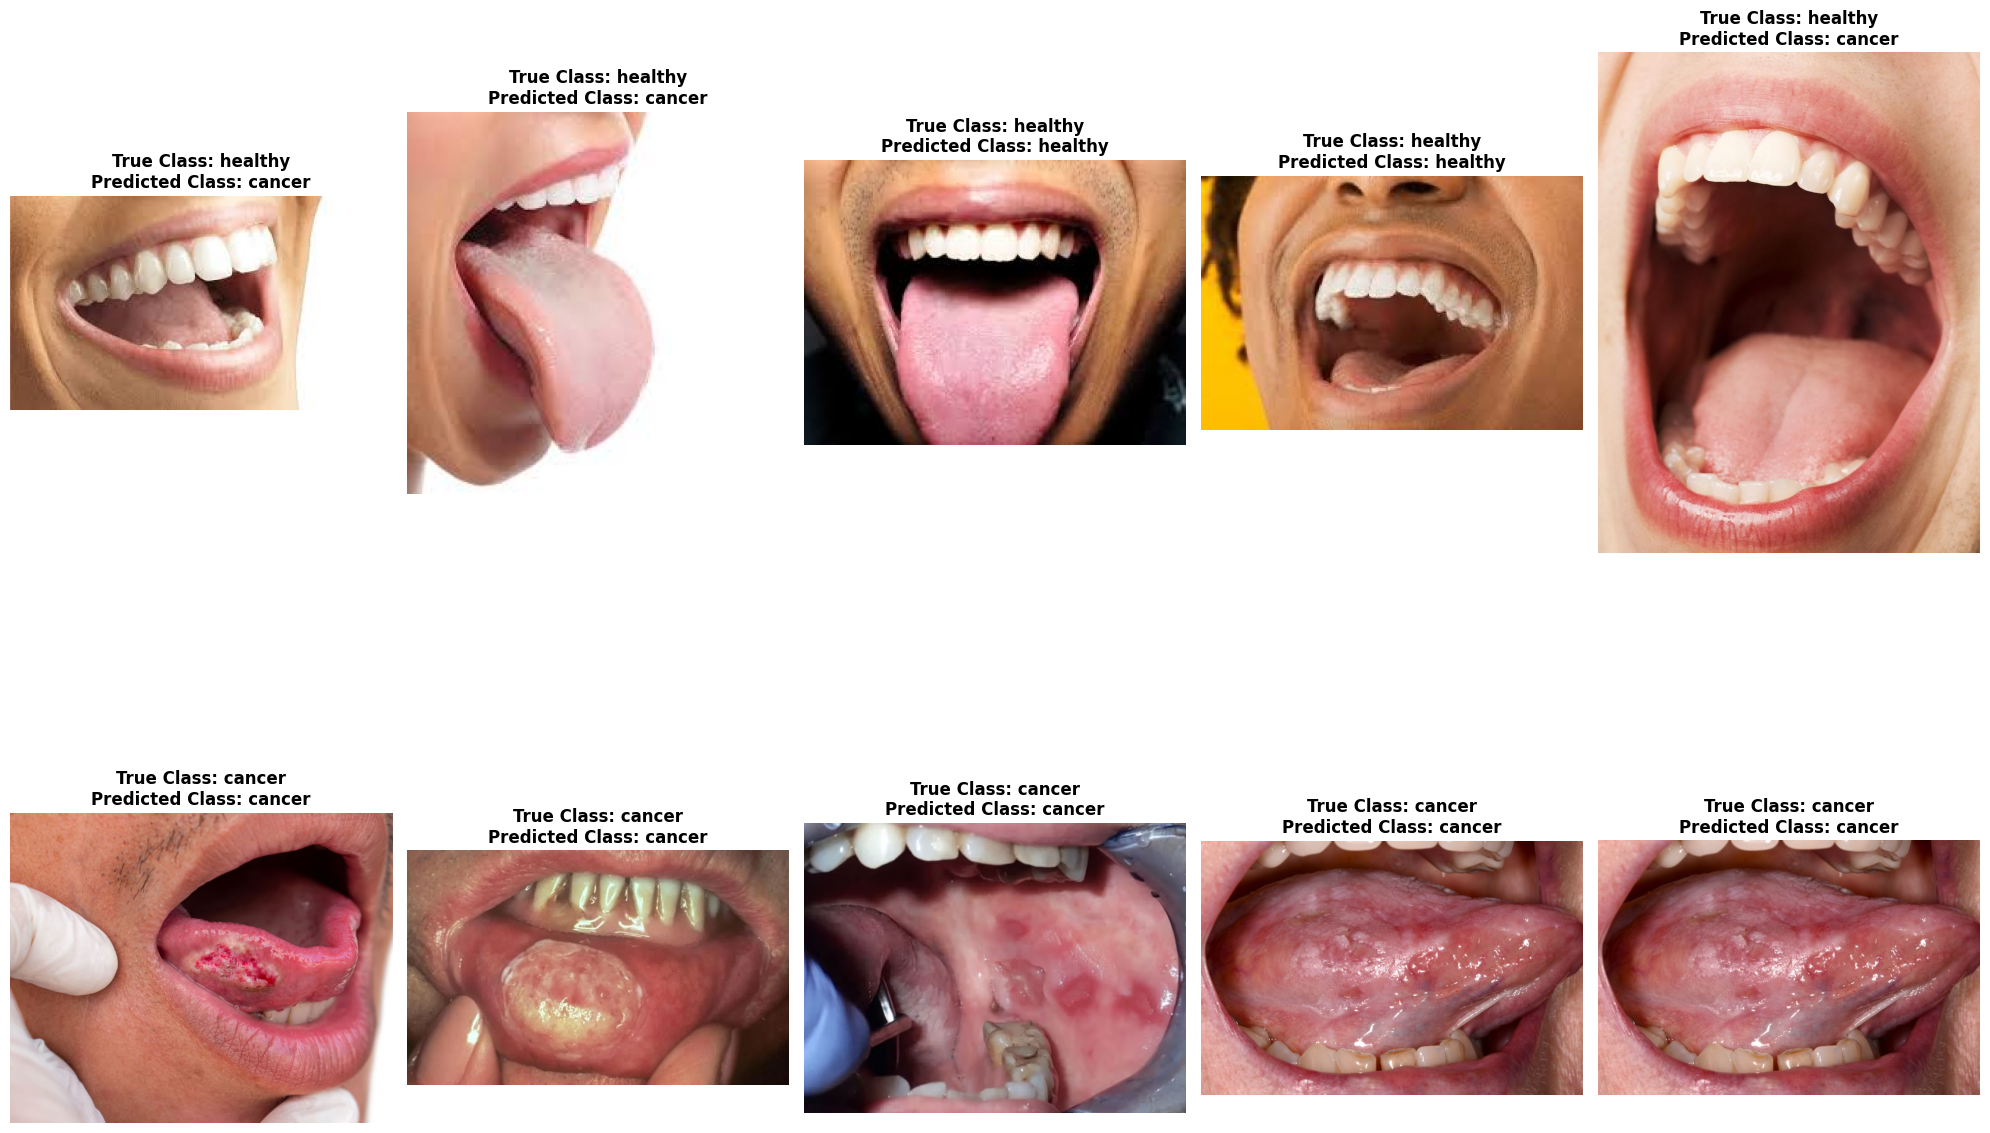

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Constants
image_size = (224, 224)
batch_size = 32
epochs = 5 #changing epochs to 5, 25 as required
num_classes = 2  # number of classes
class_names = ['cancer', 'healthy']  # Updated class names to match alphabetical order

# Data paths
train_dir = '/content/drive/MyDrive/OralCancer/train'
val_dir = '/content/drive/MyDrive/OralCancer/valid'
test_dir = '/content/drive/MyDrive/OralCancer/test'
results_dir = '/content/drive/MyDrive/OralCancer/results'

# Ensure the results directory exists
os.makedirs(results_dir, exist_ok=True)

# Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Verify class indices
print(f"Class indices: {train_generator.class_indices}")

# Ensure the class indices are as expected (0: cancer, 1: healthy)
assert train_generator.class_indices == {'cancer': 0, 'healthy': 1}, "Class indices are not as expected!"

# Model
base_model = tf.keras.applications.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Testing
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Predict test labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Correct the mapping of class indices
true_classes = test_generator.classes
predicted_classes = y_pred

# Save Results to Excel
excel_path = os.path.join(results_dir, 'xcp_test_results.xlsx')

# Check if the file is accessible
if os.path.exists(excel_path):
    try:
        os.rename(excel_path, excel_path)  # Try to rename the file to check if it is being used
    except OSError:
        raise PermissionError(f"Cannot access the file {excel_path}. Please close it if it is open in another program.")

results_df = pd.DataFrame({
    'Test Image': test_generator.filenames,
    'True Class': [class_names[i] for i in true_classes],
    'Predicted Class': [class_names[i] for i in predicted_classes]
})

results_df.to_excel(excel_path, index=False)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            annot_kws={"size": 16, "weight": "bold", "color": "black"})
plt.xlabel('Predicted Class', fontsize=16, weight='bold')
plt.ylabel('True Class', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)
plt.tight_layout(pad=3)  # Adjust the padding as needed
plt.savefig(os.path.join(results_dir, 'xcp_confusion_matrix.png'))
plt.show()

# Classification Report
classification_rep = classification_report(true_classes, predicted_classes, target_names=class_names)
print(classification_rep)

# ROC Plot for multi-class classification
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes == i, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC Curve ({class_names[i]}, area = {roc_auc:.2f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
plt.title('ROC Curve for Multi-Class Classification', fontsize=16, weight='bold')
plt.legend(loc='lower right')
plt.savefig(os.path.join(results_dir, 'xcp_roc_curve.png'))
plt.show()

# Function to plot images with labels
def plot_images(images, labels, predicted_labels, class_names, rows=1, figsize=(20, 15), save_path=None):
    fig, axes = plt.subplots(rows, len(images)//rows, figsize=figsize, dpi=100)
    fig.subplots_adjust(hspace=0.5)
    axes = axes.flatten()
    for i, (image, label, predicted_label) in enumerate(zip(images, labels, predicted_labels)):
        axes[i].imshow(image)
        axes[i].axis('off')
        title = f'True Class: {class_names[label]}\nPredicted Class: {class_names[predicted_label]}'
        axes[i].set_title(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)
    plt.show()

# Function to process testing results and select random images
def process_testing_results(excel_file, test_folder, save_filename):
    # Read testing results from Excel
    df = pd.read_excel(excel_file)

    # Normalize paths for consistency
    df['Test Image'] = df['Test Image'].apply(lambda x: os.path.normpath(x).replace("\\", "/"))

    # Ensure correct mapping between image filenames and true labels
    filename_to_true_label = dict(zip(df['Test Image'], df['True Class']))

    # Select random images from each class folder
    healthy_images = random.sample(os.listdir(os.path.join(test_folder, 'healthy')), 5)
    cancer_images = random.sample(os.listdir(os.path.join(test_folder, 'cancer')), 5)

    # Load and plot the selected images with labels
    selected_images = [os.path.join(test_folder, 'healthy', img) for img in healthy_images] + \
                      [os.path.join(test_folder, 'cancer', img) for img in cancer_images]

    # Get true and predicted labels based on selected images
    selected_labels = [class_names.index(filename_to_true_label[os.path.normpath(os.path.relpath(img, test_folder)).replace("\\", "/")]) for img in selected_images]
    random_predicted_labels = [class_names.index(df.loc[df['Test Image'] == os.path.normpath(os.path.relpath(img, test_folder)).replace("\\", "/"), 'Predicted Class'].values[0]) for img in selected_images]

    # Load images using PIL
    images = [Image.open(img_path) for img_path in selected_images]

    # Save path for the image
    save_path = os.path.join(os.path.dirname(excel_file), save_filename)

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Plot images with labels and save
    plot_images(images, selected_labels, random_predicted_labels, class_names, rows=2, save_path=save_path)

# Process the testing results and generate labelled images
process_testing_results(excel_path, test_dir, os.path.join(results_dir, 'xcp_labelled_images.png'))
